In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SQLContext
import pyspark
sc = pyspark.SparkContext.getOrCreate()

In [45]:
print("Reading the 'covid_19_india.csv' dataset into pandas dataframe:")
df = pd.read_csv('/usr/data/kaggle/covid19-in-india/covid_19_india.csv')
df

Reading the 'covid_19_india.csv' dataset into pandas dataframe:


,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed
0,1,30/01/20,6:00 PM,Kerala,1,0,0,0,1
1,2,31/01/20,6:00 PM,Kerala,1,0,0,0,1
2,3,01/02/20,6:00 PM,Kerala,2,0,0,0,2
3,4,02/02/20,6:00 PM,Kerala,3,0,0,0,3
4,5,03/02/20,6:00 PM,Kerala,3,0,0,0,3
...,...,...,...,...,...,...,...,...,...
987,988,15/04/20,5:00 PM,Telengana,-,-,120,18,647
988,989,15/04/20,5:00 PM,Tripura,-,-,0,0,2
989,990,15/04/20,5:00 PM,Uttarakhand,-,-,9,0,37
990,991,15/04/20,5:00 PM,Uttar Pradesh,-,-,51,11,735


In [36]:
print(f"Correlation between Deaths and Confirmed cases: {df['Deaths'].corr(df['Confirmed'])}") 

Correlation between Deaths and Confirmed cases: 0.8146433454975103


Let's see this correlation by a scatter plot:
As we can see:  the more confirmed cases ---> the more death cases


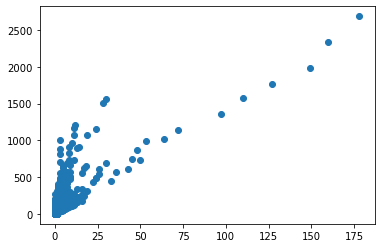

In [43]:
print("Let's see this correlation by a scatter plot:")
plt.scatter(df['Deaths'],df['Confirmed'])
print("As we can see:  the more confirmed cases ---> the more death cases")

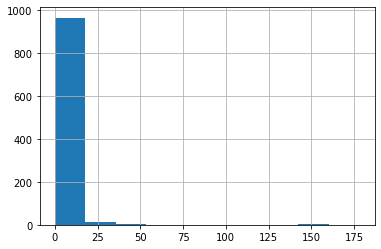

In [26]:
df['Deaths'].hist()

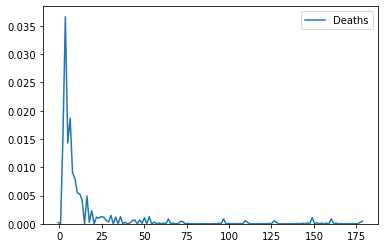

In [28]:
sns.kdeplot(df['Deaths'])

In [19]:
df['Date'].value_counts()

14/04/20    33
15/04/20    33
13/04/20    32
08/04/20    31
10/04/20    31
            ..
20/02/20     1
29/02/20     1
19/02/20     1
02/02/20     1
06/02/20     1
Name: Date, Length: 77, dtype: int64

In [27]:
import pyspark
import math
sc = pyspark.SparkContext.getOrCreate()
sqlContext = pyspark.sql.SQLContext(sc)

print("Reading the 'population_india_census2011.csv' dataset to rdd")
population_rdd = sc.textFile("/usr/data/kaggle/covid19-in-india/population_india_census2011.csv")
headers = population_rdd.first()
population_rdd = population_rdd.filter(lambda line: line != headers)
population_rdd = population_rdd.map(lambda line: line.split(","))
population_rdd = population_rdd.map(lambda line: (line[1], line[2], line[6]))
population_df = population_rdd.map(lambda line: (line[0], int(line[1]), math.ceil(float(line[2].split('/')[0])))).toDF(["state", "population", "density"])
population_df.toPandas()

Reading the 'population_india_census2011.csv' dataset to rdd


,state,population,density
0,Uttar Pradesh,199812341,828
1,Maharashtra,112374333,365
2,Bihar,104099452,1102
3,West Bengal,91276115,1029
4,Madhya Pradesh,72626809,236
5,Tamil Nadu,72147030,555
6,Rajasthan,68548437,201
7,Karnataka,61095297,319
8,Gujarat,60439692,308
9,Andhra Pradesh,49577103,303


In [28]:
import pyspark
from pyspark.sql import *
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql.functions import col, max as max_

sc = pyspark.SparkContext.getOrCreate()
sqlContext = pyspark.sql.SQLContext(sc)

print("Reading the 'covid_19_india.csv' dataset to rdd")
raw_covid_file = sc.textFile("/usr/data/kaggle/covid19-in-india/covid_19_india.csv")

headers = raw_covid_file.first()
raw_data = raw_covid_file.filter(lambda line: line != headers)
split_data = raw_data.map(lambda line: line.split(","))

df = split_data.map(lambda line: (line[3], datetime.strptime(line[1], '%d/%m/%y'), int(line[6]), int(line[7]), int(line[8])))\
                .toDF(["state", "datetime", "cured", "deaths", "confirmed"])


most_recent = df.withColumn("datetime", col("datetime")).\
                                    groupBy("state")\
                                    .agg(max_("datetime"))


joined = df.join(most_recent, [(df.state == most_recent.state) & (df["datetime"]==most_recent["max(datetime)"])])\
.select(df.state, "datetime", "cured", "deaths", "confirmed")
joined.toPandas()


Reading the 'covid_19_india.csv' dataset to rdd


,state,datetime,cured,deaths,confirmed
0,Manipur,2020-04-15,1,0,2
1,Telengana,2020-04-15,120,18,647
2,Tripura,2020-04-15,0,0,2
3,West Bengal,2020-04-15,37,7,213
4,Rajasthan,2020-04-15,147,3,1005
5,Nagaland#,2020-04-15,0,0,0
6,Mizoram,2020-04-15,0,0,1
7,Assam,2020-04-15,0,1,33
8,Jammu and Kashmir,2020-04-15,30,4,278
9,Madhya Pradesh,2020-04-15,64,53,987


In [33]:
pd = joined.join(population_df, ["state"]).toPandas()
pd

,state,datetime,cured,deaths,confirmed,population,density
0,Nagaland,2020-04-14,0,0,1,1978502,119
1,Karnataka,2020-04-15,75,11,277,61095297,319
2,Odisha,2020-04-15,18,1,60,41974218,269
3,Kerala,2020-04-15,211,3,387,33406061,859
4,Ladakh,2020-04-15,10,0,17,274000,3
5,Tamil Nadu,2020-04-15,81,12,1204,72147030,555
6,Telengana,2020-04-15,120,18,647,35003674,312
7,Chhattisgarh,2020-04-15,13,0,33,25545198,189
8,Andhra Pradesh,2020-04-15,16,9,503,49577103,303
9,Madhya Pradesh,2020-04-15,64,53,987,72626809,236


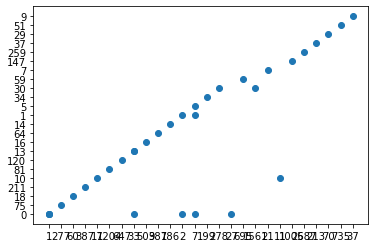

In [356]:
plt.scatter(pd["confirmed"], pd["cured"])

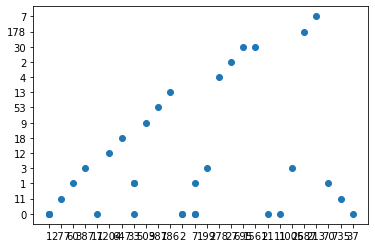

In [357]:
plt.scatter(pd["confirmed"], pd["deaths"])

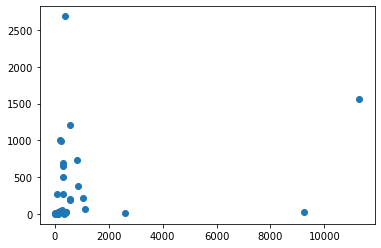

In [31]:
plt.scatter(pd["density"], pd["confirmed"])

{'whiskers': [<matplotlib.lines.Line2D at 0x7f3220245f50>,
 'caps': [<matplotlib.lines.Line2D at 0x7f322022ae50>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f322022ae90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f32202565d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f32202457d0>],
 'means': []}

<Figure size 1440x1440 with 0 Axes>

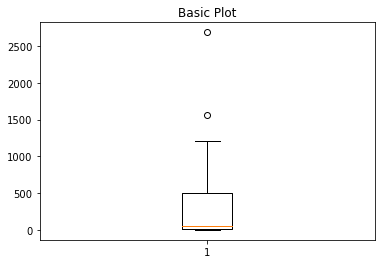

In [40]:
plt.figure(figsize=(20,20))
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(pd["confirmed"])

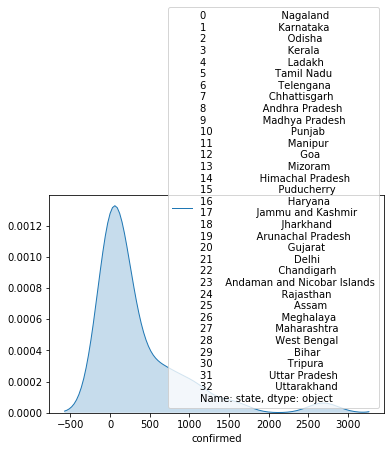

In [49]:

import seaborn as sns
sns.distplot(pd["confirmed"], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 1}, 
                  label = pd["state"])